In [1]:
import argparse
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime
import time
import logging
from joblib import dump, load
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import RegressorChain
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import lightgbm as lightgbm

# settings:
numberOfInputWeeks = 3 # must be equal to the number of input weeks set in data preperator
numberOfOutputWeeks = 4 # must be equal to the number of output week set in data preperator



# data preperation
cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']
data = pd.read_csv("completedata.csv")


outputCategories = ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]
numberOfOutputs = len(outputCategories)

split = numberOfOutputs * numberOfOutputWeeks + 2

train_features = data[(data['category']=='train') | (data['category']=='validation 1') | (data['category']=='validation 2')].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
train_labels = data[(data['category']=='train') | (data['category']=='validation 1') | (data['category']=='validation 2')].iloc[:,-split:-2]

test1_features = data[data['category']=='test 1'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
test1_labels = data[data['category']=='test 1'].iloc[:,-split:-2]
test2_features = data[data['category']=='test 2'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
test2_labels = data[data['category']=='test 2'].iloc[:,-split:-2]
test1And2_labels = data[(data['category']=='test 1') | (data['category']=='test 2')].iloc[:,-split:-2]
test1And2_features = data[(data['category']=='test 1') | (data['category']=='test 2')].iloc[:,0:-split].drop(['lastInputDay'], axis=1)

pip = Pipeline([('minmax_scaler', MinMaxScaler())])
X_train = pip.fit_transform(train_features[train_features.columns].values)
X_test1 = pip.transform(test1_features[train_features.columns].values)
X_test2 = pip.transform(test2_features[train_features.columns].values)
X_test1And2 = pip.transform(test1And2_features[train_features.columns].values)


    
def generic1(learningrate, hiddenLayers, dropout, l1, l2, isMultiOutput):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hiddenLayers[0], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2), input_shape=X_train.shape[1:]))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(numberOfOutputWeeks) if isMultiOutput else keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model
    
def generic2(learningrate, hiddenLayers, dropout, l1, l2, isMultiOutput):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hiddenLayers[0], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2), input_shape=X_train.shape[1:]))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[1], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(numberOfOutputWeeks) if isMultiOutput else keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model

def generic3(learningrate, hiddenLayers, dropout, l1, l2, isMultiOutput):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hiddenLayers[0], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2), input_shape=X_train.shape[1:]))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[1], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[2], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(numberOfOutputWeeks) if isMultiOutput else keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model

def generic4(learningrate, hiddenLayers, dropout, l1, l2, isMultiOutput):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hiddenLayers[0], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2), input_shape=X_train.shape[1:]))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[1], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[2], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[3], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(numberOfOutputWeeks) if isMultiOutput else keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model

def generic5(learningrate, hiddenLayers, dropout, l1, l2, isMultiOutput):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hiddenLayers[0], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2), input_shape=X_train.shape[1:]))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[1], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[2], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[3], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[4], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(numberOfOutputWeeks) if isMultiOutput else keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model

def generic6(learningrate, hiddenLayers, dropout, l1, l2, isMultiOutput):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hiddenLayers[0], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2), input_shape=X_train.shape[1:]))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[1], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[2], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[3], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[4], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[5], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(numberOfOutputWeeks) if isMultiOutput else keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model

def generic7(learningrate, hiddenLayers, dropout, l1, l2, isMultiOutput):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hiddenLayers[0], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2), input_shape=X_train.shape[1:]))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[1], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[2], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[3], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[4], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[5], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[6], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(numberOfOutputWeeks) if isMultiOutput else keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model

def generic8(learningrate, hiddenLayers, dropout, l1, l2, isMultiOutput):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hiddenLayers[0], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2), input_shape=X_train.shape[1:]))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[1], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[2], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[3], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[4], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[5], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[6], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(hiddenLayers[7], activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(keras.layers.Dense(numberOfOutputWeeks) if isMultiOutput else keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model
    

    
def genericKerasModel(learningrate, hiddenLayers, dropout, l1regularization, l2regularization, isMultioutput):
    if len(hiddenLayers) == 1:
        return generic1(learningrate, hiddenLayers, dropout, l1regularization, l2regularization, isMultioutput)
    elif len(hiddenLayers) == 2:
        return generic2(learningrate, hiddenLayers, dropout, l1regularization, l2regularization, isMultioutput)
    elif len(hiddenLayers) == 3:
        return generic3(learningrate, hiddenLayers, dropout, l1regularization, l2regularization, isMultioutput)
    elif len(hiddenLayers) == 4:
        return generic4(learningrate, hiddenLayers, dropout, l1regularization, l2regularization, isMultioutput)
    elif len(hiddenLayers) == 5:
        return generic5(learningrate, hiddenLayers, dropout, l1regularization, l2regularization, isMultioutput)
    elif len(hiddenLayers) == 6:
        return generic6(learningrate, hiddenLayers, dropout, l1regularization, l2regularization, isMultioutput)
    elif len(hiddenLayers) == 7:
        return generic7(learningrate, hiddenLayers, dropout, l1regularization, l2regularization, isMultioutput)
    else:
        return generic8(learningrate, hiddenLayers, dropout, l1regularization, l2regularization, isMultioutput)

NameError: name 'plt' is not defined

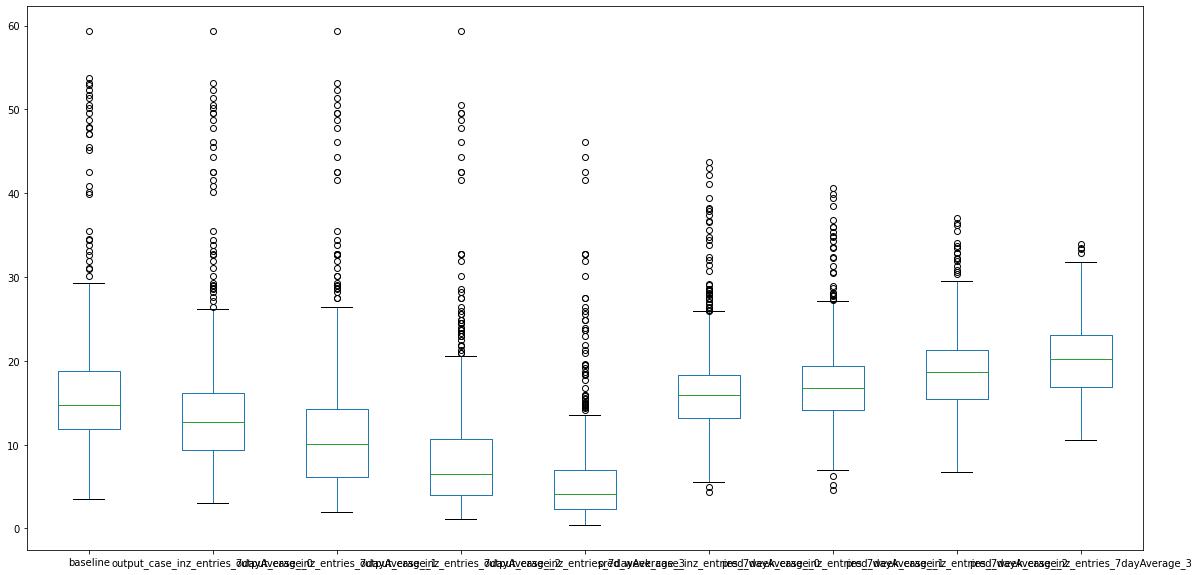

In [10]:
estimators = []
numberOfEstimators = 0
results = pd.DataFrame()

'''
parser = argparse.ArgumentParser()
parser.add_argument("jobnr", help="computes job",type=int)
args = parser.parse_args()
jobnr = args.jobnr
'''
jobnr = 99


# Test

# 'case_inz_entries_7dayAverage'
estimators.append({
                      "modelClass": "MultiTaskLasso",
                      "isMultiWeek": True,
                      "alpha": 0.7,
                      "tol": 1e-05,
                      "task":'case_inz_entries_7dayAverage',
                  }
                )

'''
# 'hosp_inz_entries_7dayAverage'
estimators.append({
                      "modelClass": "MultiTaskLasso",
                      "isMultiWeek": True,
                      "alpha": 0.014,
                      "tol": 0.0001,
                      "task":'hosp_inz_entries_7dayAverage',
                  }
                )


# 'death_inz_entries_7dayAverage'
estimators.append({
                      "modelClass": "Lasso",
                      "isMultiWeek": True,
                      "tol": 0.0001,
                      "alpha": 0.0009,
                      "task":'death_inz_entries_7dayAverage',
                  }
                )



# 'testPositvity_7dayAverageBoth'
estimators.append({
                      "modelClass": "Keras",
                      "isMultiWeek": True,
                      "hiddenLayers": [350, 175, 85],
                      "numberOfhiddenLayers": 3,
                      "isTwoWay": False,
                      "l1reg": 0,
                      "alpha": 0.0001,
                      "dropoutValue": 0,
                      "learningRate": 0.0001,
                      "task":'testPositvity_7dayAverage',
                      "epochs":73
                  }
                )


# 'workplaces_percent_change_from_baseline_7dayAverage'
estimators.append({
                      "modelClass": "RandomForrest",
                      "isMultiWeek": True,
                      "n_estimators": 1000,
                      "max_features": 'auto',
                      "min_samples_leaf": 8,
                      "task":'workplaces_percent_change_from_baseline_7dayAverage',
                  }
                )

# 'transit_stations_percent_change_from_baseline_7dayAverage'
estimators.append({
                      "modelClass": "Keras",
                      "isMultiWeek": True,
                      "hiddenLayers": [500, 250],
                      "numberOfhiddenLayers": 2,
                      "isTwoWay": False,
                      "l1reg": 0.001,
                      "alpha": 0.0001,
                      "dropoutValue": 0.5,
                      "learningRate": 0.0001,
                      "task":'transit_stations_percent_change_from_baseline_7dayAverage',
                      "epochs":94
                  }
                )
'''






    

# constructs and saves the results of a fitted estimator    
def constructResults(estimator, task, numberOfRanEpochs):
    # predictions for all weeks
    predictions1 = pd.DataFrame(estimator.predict(X_test1), index=test1_labels.index, columns=["pred_week_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]) 
    predictions2 = pd.DataFrame(estimator.predict(X_test2), index=test2_labels.index, columns=["pred_week_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)])

    # test for all weeks
    y_test1 = test1_labels[["output_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]]
    y_test2 = test2_labels[["output_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]]

    plotDf = pd.DataFrame()
    plotDf['true'] = test1_labels["output_"+task+"_"+str(3)]
    plotDf['prediction'] = predictions1["pred_week_"+task+"_"+str(3)]
    plotDf['baseline'] = test1_features[task+"_last_"+str(numberOfInputWeeks-1)]
    #pd.concat([plotDf['baseline'],plotDf['true'],plotDf['prediction'],], axis=1)
    plotDf = pd.concat([plotDf['baseline'],y_test1,predictions1], axis=1)
    plotDf.plot(kind='box', figsize=(20,10))
    plt.show()
    
    resultsDf = pd.DataFrame()
    # compute and safe results for every week
    for outputWeekNumber in range(0,numberOfOutputWeeks):
        # compute root mean squared error for test sets
        rmse1 = np.sqrt(mean_squared_error(predictions1["pred_week_"+task+"_"+str(outputWeekNumber)], y_test1["output_"+task+"_"+str(outputWeekNumber)]))
        rmse2 = np.sqrt(mean_squared_error(predictions2["pred_week_"+task+"_"+str(outputWeekNumber)], y_test2["output_"+task+"_"+str(outputWeekNumber)]))
        # safe the results and all model parameters
        res = {}
        if estimators[estimatorId]["modelClass"] == "Keras":
            res = {'modelId':[generateModelId(estimators[estimatorId])],
                  'modelClass':[estimators[estimatorId]["modelClass"]],
                 'task':[task],
                 'week':[outputWeekNumber], 
                 'model rmse 1':[rmse1], 
                 'model rmse 2':[rmse2],
                 'isMultiWeek':[estimators[estimatorId]["isMultiWeek"]],
                 "hiddenLayers":[estimators[estimatorId]["hiddenLayers"]],
                 "numberOfhiddenLayers":[len(estimators[estimatorId]["hiddenLayers"])],
                 "isTwoWay": [estimators[estimatorId]["isTwoWay"]],
                 "l1reg": [estimators[estimatorId]["l1reg"]],
                 "alpha": [estimators[estimatorId]["alpha"]],
                 "dropoutValue":[estimators[estimatorId]["dropoutValue"]],
                 "learningRate":[estimators[estimatorId]["learningRate"]],
                 "numberOfRanEpochs": [numberOfRanEpochs]
                }
        elif estimators[estimatorId]["modelClass"] == "RandomForrest":
            res = {'modelId':[generateModelId(estimators[estimatorId])],
                   'modelClass':[estimators[estimatorId]["modelClass"]],
                 'task':[task],
                 'week':[outputWeekNumber], 
                 'model rmse 1':[rmse1], 
                 'model rmse 2':[rmse2],
                 'isMultiWeek':[estimators[estimatorId]["isMultiWeek"]],
                 "n_estimators": [estimators[estimatorId]["n_estimators"]],
                 "max_features": [estimators[estimatorId]["max_features"]],
                 "min_samples_leaf": [estimators[estimatorId]["min_samples_leaf"]]
                }               
        
        elif estimators[estimatorId]["modelClass"] == "Lasso":
            res = {'modelId':[generateModelId(estimators[estimatorId])],
                   'modelClass':[estimators[estimatorId]["modelClass"]],
                 'task':[task],
                 'week':[outputWeekNumber], 
                 'model rmse 1':[rmse1], 
                 'model rmse 2':[rmse2],
                 'isMultiWeek':[estimators[estimatorId]["isMultiWeek"]],
                 "alpha": [estimators[estimatorId]["alpha"]],
                 "tol": [estimators[estimatorId]["tol"]]
                }
        elif estimators[estimatorId]["modelClass"] == "MultiTaskLasso":
            res = {'modelId':[generateModelId(estimators[estimatorId])],
                   'modelClass':[estimators[estimatorId]["modelClass"]],
                 'task':[task],
                 'week':[outputWeekNumber], 
                 'model rmse 1':[rmse1], 
                 'model rmse 2':[rmse2],
                 'isMultiWeek':[estimators[estimatorId]["isMultiWeek"]],
                 "alpha": [estimators[estimatorId]["alpha"]],
                 "tol": [estimators[estimatorId]["tol"]]
                }
        else:
            raise ValueError('Tried to save results for an unsupported estimator')
        resultsDf = resultsDf.append(pd.DataFrame(data=res), ignore_index = True)
    return resultsDf
   

        
def generateModelId(dictionary):
    modelId = ""
    for key in dictionary.keys():
        modelId = modelId + key +"="+ str(dictionary[key]) +"/"
    modelId = modelId[0:-1]
    return modelId    
    

# training


for estimatorId in range(0,len(estimators)):

    # get train labels for all weeks
    y_train = train_labels[["output_"+estimators[estimatorId]["task"]+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]].values
    if estimators[estimatorId]["modelClass"] == "Keras":
        # get test labels for all weeks (used for early stopping)
        y_test1And2 = test1And2_labels[["output_"+estimators[estimatorId]["task"]+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]].values 
        # construct Keras model

        estimator = genericKerasModel(
            estimators[estimatorId]["learningRate"],
            estimators[estimatorId]["hiddenLayers"],
            estimators[estimatorId]["dropoutValue"],
            estimators[estimatorId]["l1reg"],
            estimators[estimatorId]["alpha"],
            estimators[estimatorId]["isMultiWeek"]
        )

        # fit Keras model
        history = estimator.fit(X_train, 
          y_train, 
          batch_size=32, 
          epochs=estimators[estimatorId]["epochs"], 
          verbose=0)
        
        
        if not os.path.exists('models/trainedOnTrainingAndValidationData/'):
            os.makedirs('models')
            os.makedirs('models/trainedOnTrainingAndValidationData/')
        estimator.save("models/trainedOnTrainingAndValidationData/"+str(jobnr)+"_"+estimators[estimatorId]["task"])
        
        
        numberOfRanEpochs = len(history.history['loss'])
        results = results.append(constructResults(estimator, estimators[estimatorId]["task"], numberOfRanEpochs), ignore_index = True)

    elif estimators[estimatorId]["modelClass"] == "RandomForrest":
        estimator = RandomForestRegressor(n_estimators=estimators[estimatorId]["n_estimators"], 
                                          max_features=estimators[estimatorId]["max_features"],
                                          min_samples_leaf=estimators[estimatorId]["min_samples_leaf"],
                                          n_jobs=-1
                                         )
        estimator.fit(X_train,y_train)
        dump(estimator, "models/trainedOnTrainingAndValidationData/"+str(estimatorId)+"_"+estimators[estimatorId]["task"]+"_sklearn.pkl")
        results = results.append(constructResults(estimator, estimators[estimatorId]["task"], -1), ignore_index = True)
    elif estimators[estimatorId]["modelClass"] == "Lasso":
        estimator = linear_model.Lasso(alpha=estimators[estimatorId]["alpha"],
                                               tol = estimators[estimatorId]["tol"])
        estimator.fit(X_train,y_train)
        dump(estimator, "models/trainedOnTrainingAndValidationData/"+str(estimatorId)+"_"+estimators[estimatorId]["task"]+"_sklearn.pkl")
        results = results.append(constructResults(estimator, estimators[estimatorId]["task"], -1), ignore_index = True)
    elif estimators[estimatorId]["modelClass"] == "MultiTaskLasso":
        estimator = linear_model.MultiTaskLasso(alpha = estimators[estimatorId]["alpha"],
                                               tol = estimators[estimatorId]["tol"])
        estimator.fit(X_train,y_train)
        dump(estimator, "models/trainedOnTrainingAndValidationData/"+str(estimatorId)+"_"+estimators[estimatorId]["task"]+"_sklearn.pkl")
        results = results.append(constructResults(estimator, estimators[estimatorId]["task"], -1), ignore_index = True)
    else:
        raise ValueError('Tried to fit an unsupported estimator')            
    

'''
results['iteration'] = jobnr
    

if not os.path.exists('test_results/'):
    os.makedirs('test_results')
results.to_csv("test_results/"+str(jobnr)+".csv", header=True, index=False)
'''
display(results)

In [ ]:
'''
results = pd.read_csv("test_results/"+str(jobnr)+".csv", low_memory=False)

for task in outputCategories: # for all output tasks
    for outputWeekNumber in range(0,numberOfOutputWeeks): # for every output week

        # get the ground truth
        groundtruth1 = test1_labels[["output_"+task+"_"+str(outputWeekNumber)]]
        groundtruth2 = test2_labels[["output_"+task+"_"+str(outputWeekNumber)]]

        # get the easy baseline (is the same for all output weeks)
        last_value_baseline1 = test1_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
        last_value_baseline2 = test2_features[[task+"_last_"+str(numberOfInputWeeks-1)]]

        last_value_baseline1_rmse = np.sqrt(mean_squared_error(last_value_baseline1,groundtruth1))
        last_value_baseline2_rmse = np.sqrt(mean_squared_error(last_value_baseline2,groundtruth2))


        results.loc[(results.task == task) & (results.week == outputWeekNumber),'last value baseline 1 rmse']=last_value_baseline1_rmse
        results.loc[(results.task == task) & (results.week == outputWeekNumber),'last value baseline 2 rmse']=last_value_baseline2_rmse

results = results[['modelId','task','week','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse']]

results['week'] = results['week']+1


for task in outputCategories:
    temp2 = results[results['task']==task]
    temp2 = temp2.groupby(['modelId']).sum()
    # add relative score
    temp2['rel. diff. to last value baseline 1'] = (temp2['last value baseline 1 rmse']-temp2['model rmse 1'])/temp2['last value baseline 1 rmse']
    temp2['rel. diff. to last value baseline 2'] = (temp2['last value baseline 2 rmse']-temp2['model rmse 2'])/temp2['last value baseline 2 rmse']
    display(temp2)
'''

In [32]:
'''
estimator = load('models/trainedOnTrainingAndValidationData/0_case_inz_entries_7dayAverage_sklearn.pkl')
task = 'case_inz_entries_7dayAverage'

'''
'''
estimator = load('models/trainedOnTrainingAndValidationData/1_hosp_inz_entries_7dayAverage_sklearn.pkl')
task = 'hosp_inz_entries_7dayAverage'


estimator = load('models/trainedOnTrainingAndValidationData/2_death_inz_entries_7dayAverage_sklearn.pkl')
task = 'death_inz_entries_7dayAverage'

                  

predictions1 = pd.DataFrame(estimator.predict(X_test1), index=test1_labels.index, columns=["pred_week_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]) 
predictions2 = pd.DataFrame(estimator.predict(X_test2), index=test2_labels.index, columns=["pred_week_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)])

# test for all weeks
y_test1 = test1_labels[["output_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]]
y_test2 = test2_labels[["output_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]]

resultsDf = pd.DataFrame()
# compute and safe results for every week
for outputWeekNumber in range(0,numberOfOutputWeeks):
    # compute root mean squared error for test sets
    rmse1 = np.sqrt(mean_squared_error(predictions1["pred_week_"+task+"_"+str(outputWeekNumber)], y_test1["output_"+task+"_"+str(outputWeekNumber)]))
    rmse2 = np.sqrt(mean_squared_error(predictions2["pred_week_"+task+"_"+str(outputWeekNumber)], y_test2["output_"+task+"_"+str(outputWeekNumber)]))

    
    groundtruth1 = test1_labels[["output_"+task+"_"+str(outputWeekNumber)]]
    groundtruth2 = test2_labels[["output_"+task+"_"+str(outputWeekNumber)]]
    
    temp = pd.DataFrame(predictions1["pred_week_"+task+"_"+str(outputWeekNumber)])
    temp = temp.join(groundtruth1)
    display(temp.plot(kind='box', ylabel='7 day case incidence average', figsize=(10,5)))

    # get the easy baseline (is the same for all output weeks)
    last_value_baseline1 = test1_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
    last_value_baseline2 = test2_features[[task+"_last_"+str(numberOfInputWeeks-1)]]

    last_value_baseline1_rmse = np.sqrt(mean_squared_error(last_value_baseline1,groundtruth1))
    last_value_baseline2_rmse = np.sqrt(mean_squared_error(last_value_baseline2,groundtruth2))
    
    
    res = {
         'week':[outputWeekNumber], 
         'model rmse 1':[rmse1], 
         'model rmse 2':[rmse2],
         'last_value_baseline1_rmse':[last_value_baseline1_rmse], 
         'last_value_baseline2_rmse':[last_value_baseline2_rmse],
        }
    resultsDf = resultsDf.append(pd.DataFrame(data=res), ignore_index = True)

display(results)
display(resultsDf.sum())

'''


'\nestimator = load(\'models/trainedOnTrainingAndValidationData/1_hosp_inz_entries_7dayAverage_sklearn.pkl\')\ntask = \'hosp_inz_entries_7dayAverage\'\n\n\nestimator = load(\'models/trainedOnTrainingAndValidationData/2_death_inz_entries_7dayAverage_sklearn.pkl\')\ntask = \'death_inz_entries_7dayAverage\'\n\n                  \n\npredictions1 = pd.DataFrame(estimator.predict(X_test1), index=test1_labels.index, columns=["pred_week_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]) \npredictions2 = pd.DataFrame(estimator.predict(X_test2), index=test2_labels.index, columns=["pred_week_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)])\n\n# test for all weeks\ny_test1 = test1_labels[["output_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]]\ny_test2 = test2_labels[["output_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]]\n\nresultsDf = pd.Dat